In [35]:
import bayes3d as b
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

H,W = 150,150
intrinsics = b.Intrinsics(
    height=H,
    width=W,
    fx=200.0, fy=200.0,
    cx=W/2.0, cy=H/2.0,
    near=0.01, far=10.0
)
renderer = b.Renderer(intrinsics)
renderer.add_mesh(
    b.mesh.make_cuboid_mesh(jnp.array([1.0, 1.0, 1.0]))
)

Increasing frame buffer size to (width, height, depth) = (160, 160, 512)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [3]:
object_pose = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
    jnp.array([0.0, 3.5, 3.0]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
))

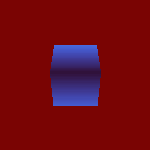

In [23]:
observed_img = renderer.render_single_object(object_pose, 0)[:,:,:3]
b.get_depth_image(img[:,:,2])

In [36]:
NUM_X_VALS = 1000
XVAL_SWEEP = jnp.linspace(-1.0, 1.0, NUM_X_VALS)
object_pose_sweep = jnp.tile(object_pose[None, None,:,:], (1, NUM_X_VALS, 1,1))
ps = object_pose_sweep = object_pose_sweep.at[0,:,0,3].set(XVAL_SWEEP)
rendered_images = renderer.render_multiobject_parallel(object_pose_sweep, [0])

In [37]:
R_SWEEP = jnp.linspace(0.001, 0.1, 200)
OUTLIER_PROB_SWEEP = jnp.linspace(0.0001, 0.1, 100)
OUTLIER_VOLUME = intrinsics.far

likelihood_parallel = jax.jit(jax.vmap(jax.vmap(
     b.threedp3_likelihood_depth_image,
    in_axes=(None, None, None, 0, None, None)),
    in_axes=(None, None, 0, None, None, None)
), static_argnames=('filter_size',))


In [38]:
from tqdm.notebook import tqdm
scores = []
for i in tqdm(range(len(rendered_images))):
    scores.append(likelihood_parallel(observed_img, rendered_images[i], R_SWEEP, OUTLIER_PROB_SWEEP, OUTLIER_VOLUME, 3))
scores = jnp.array(scores)

  0%|          | 0/1000 [00:00<?, ?it/s]

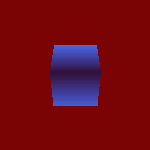

In [53]:
ii,jj,kk = jnp.unravel_index(scores.argmax(), scores.shape)
b.get_depth_image(rendered_images[ii,:,:,2])

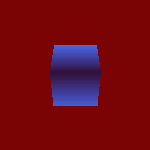

In [55]:
likelihood_parallel_over_images = jax.jit(jax.vmap(
     b.threedp3_likelihood_depth_image,
    in_axes=(None, 0, None, None, None, None)),
     static_argnames=('filter_size',))

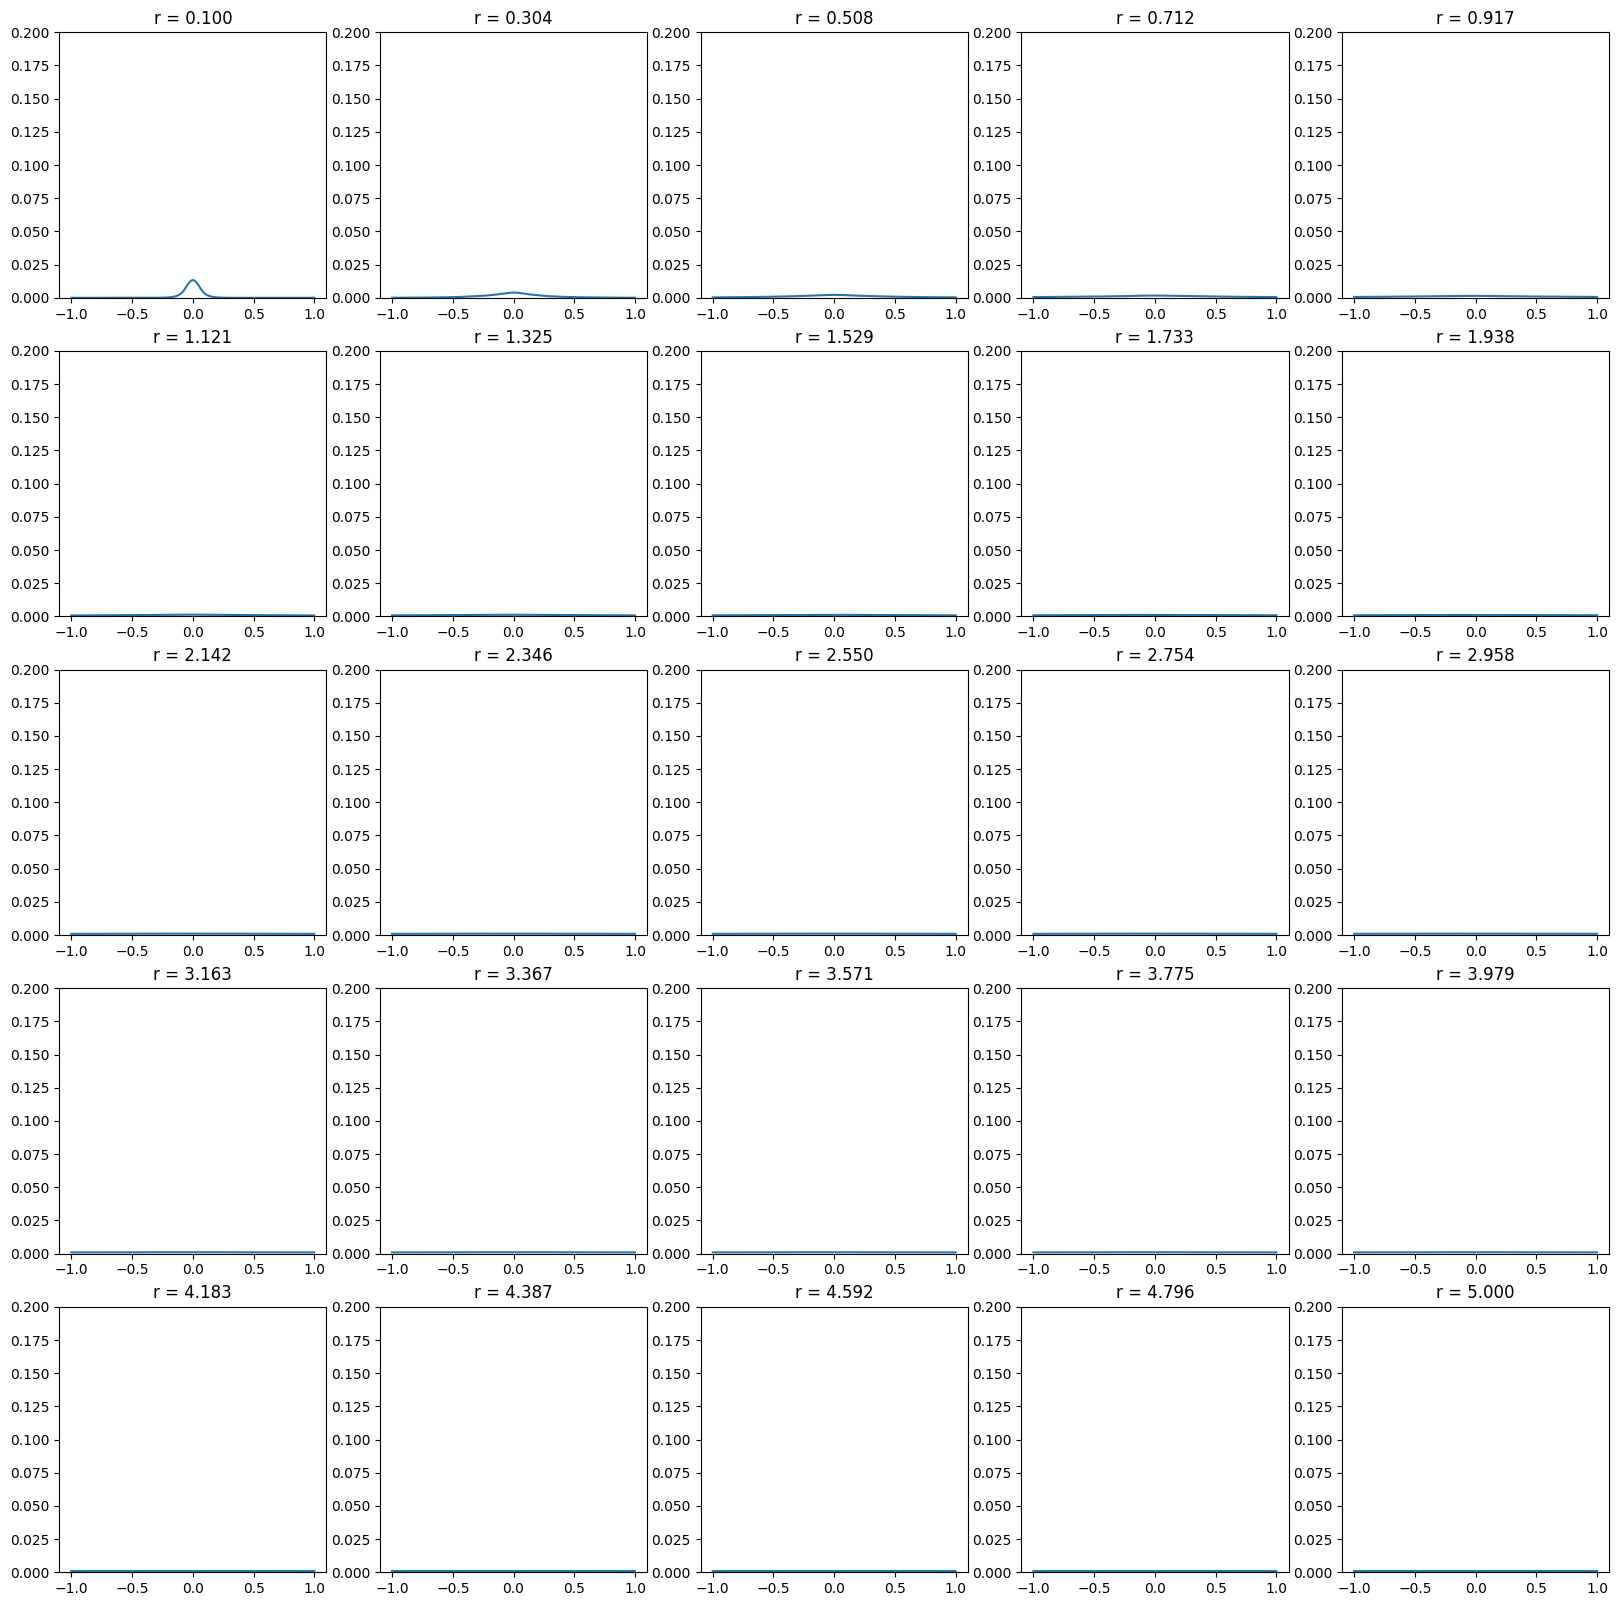

In [77]:
OUTLIER_PROB = 0.5
OUTLIER_VOLUME = 1.0
f, axarr = plt.subplots(5,5,figsize=(20, 20))
for (i,r) in  enumerate(jnp.linspace(0.1, 5.0, 25)):
    scores = likelihood_parallel_over_images(observed_img, rendered_images, r, OUTLIER_PROB, OUTLIER_VOLUME, 3)
    axarr[i//5, i%5].plot(XVAL_SWEEP, b.utils.normalize_log_scores(scores),label="{:0.3f}".format(r))
    axarr[i//5, i%5].set_ylim(0.0, 0.2)
    axarr[i//5, i%5].set_title("r = {:0.3f}".format(r))